In [141]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import *
import warnings
warnings.filterwarnings('ignore')

In [175]:
#======TEMP======#
df_orders = pd.read_csv('data\orders.csv', sep=';')

In [144]:
ALPHA = 0 # 0 para reducir coste, 1 para reducir emisiones

In [145]:
# import data from csv file
df_cities = pd.read_csv('data\cities_data_costs.csv')
norm_par = ['co2_per_unit', 'cost_per_unit']
df_norm = df_cities
for par in norm_par:
    df_norm[par] = (df_cities[par]-df_cities[par].min())/(df_cities[par].max()-df_cities[par].min())

In [146]:
def get_cost(emissions, cost):
    return ALPHA*emissions + (1-ALPHA)*cost

In [147]:
def get_cost_path(city_orig, city_dest, df_func):
    if(city_orig[2:] == city_dest[2:]):
        return 0
    pes = df_func[(df_func['city_from_name']==city_orig[2:]) & (df_func['city_to_name']==city_dest[2:])]
    if pes.empty:
        pes = df_func[(df_func['city_from_name']==city_dest[2:]) & (df_func['city_to_name']==city_orig[2:])]
    return pes['cost'].values[0]

In [148]:
def declare_costs_graph(G, ports, hubs, cities, df_func):
    for p in ports:
        for h in hubs:
            pes = get_cost_path(p, h, df_func)
            G.add_edge(p, h, cost=pes)
    for h in hubs:
        for c in cities:
            pes = get_cost_path(c, h, df_func)
            G.add_edge(h, c, cost=pes)

In [149]:
# Matrix that stores the cost of minimum path of: [port][customer][extra hub]
# extra_hub = 0 -> no extra hub, extra_hub -> extra hub - 1
def get_min_cost_matrix(G, ports, cities, df_func):
    M = np.zeros((len(ports), len(cities), len(cities)+1))
    for p in range(len(ports)):
        for c in range(len(cities)):
            M[p, c, 0] = nx.dijkstra_path_length(G, ports[p], cities[c], weight='cost')

    for p in range(len(ports)):
        for c in range(len(cities)):
            for h in range(1, len(cities)+1):
                new_path = get_cost_path(ports[p], cities[h-1], df_func) + get_cost_path(cities[h-1], cities[c], df_func)
                M[p, c, h] = min(M[p, c, 0], new_path)
    return M

['Dusseldorf' 'Zaragoza' 'Venlo' 'Bratislava' 'Hamburg' 'Rome' 'Lille'
 'Liege' 'Warsaw' 'Paris' 'Lyon' 'Marseille' 'Bordeaux' 'Milan' 'Berlin'
 'Madrid' 'Vienna' 'Munich' 'Amsterdam' 'Stockholm' 'Copenhagen'
 'Barcelona' 'Cologne' 'Athens' 'Bucharest' 'Budapest' 'Naples' 'Lisbon'
 'Turin' 'Hanover' 'Malmö' 'Helsinki' 'Prague' 'Valencia' 'Bremen'
 'Rotterdam']


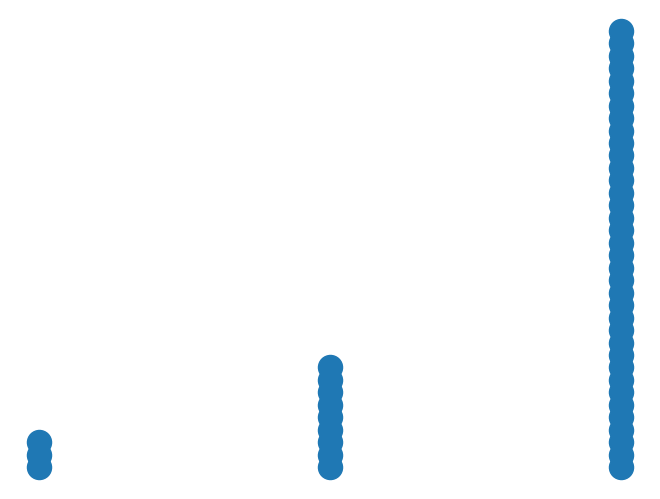

In [150]:
PORTS = ['Barcelona', 'Rotterdam', 'Athens']
HUBS = ['Hamburg', 'Lille', 'Warsaw', 'Zaragoza', 'Bratislava', 'Dusseldorf', 'Liege', 'Venlo', 'Rome']
CITIES  = df_cities['city_from_name'].unique()
print(CITIES)
PORTS = ['p-'+p for p in PORTS]
HUBS = ['h-'+h for h in HUBS]
CITIES = ['c-'+c for c in CITIES]

# create graph
G = nx.Graph()
for x in PORTS + HUBS + CITIES:
    G.add_node(x, bipartite= ['p-', 'h-', 'c-'].index(x[:2]))


nodes = G.nodes()
# for each of the parts create a set 
nodes_0  = set([n for n in nodes if  G.nodes[n]['bipartite']==0])
nodes_1  = set([n for n in nodes if  G.nodes[n]['bipartite']==1])
nodes_2  = set([n for n in nodes if  G.nodes[n]['bipartite']==2])

# set the location of the nodes for each set
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(nodes_0) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(nodes_1) ) # put nodes from Y at x=2
pos.update( (n, (3, i)) for i, n in enumerate(nodes_2) ) # put nodes from X at x=1
# draw graph
nx.draw(G, pos=pos)


In [151]:
matrixs = [] # list of matrixs for each weight class
for weight in range(10):
    df_cities_weight = df_norm.iloc[weight::10,:]
    cost = [get_cost(df_cities_weight['co2_per_unit'].iloc[i], df_cities_weight['cost_per_unit'].iloc[i]) for i in range(len(df_cities_weight))]
    df_cities_weight['cost'] = cost
    df_cities_weight = df_cities_weight.drop(columns=['co2_per_unit', 'cost_per_unit', 'city_from_coord', 'city_to_coord', 'weight_class', 'distance'])
    declare_costs_graph(G, PORTS, HUBS, CITIES, df_cities_weight)
    M = get_min_cost_matrix(G, PORTS, CITIES, df_cities_weight)
    matrixs.append(M)

In [152]:
def get_freq_matrix(df_func):
    # Matrix that stores the frequency of  path: [weight][port][customer]
    F = np.zeros((10, len(PORTS), len(CITIES)))
    for w in range(10):
        for p in range(len(PORTS)):
            for c in range(len(CITIES)):
                F[w, p, c] = np.sum(df_func.loc[(df_func['weight_class']==w) & (df_func['origin_port']==PORTS[p][2:]) & (df_func['customer']==CITIES[c][2:])]['units'].values)
    return F

In [153]:
df_orders = pd.read_csv('data\dataframefinal.csv')
F = get_freq_matrix(df_orders)

In [154]:
# we ponderate the vector with the calclated frequencies
Pond_vect = []
for extra_h in range(len(CITIES)+1):
    sum = 0
    for w in range(10):
        for p in range(len(PORTS)):
            for c in range(len(CITIES)):
                sum += F[w, p, c]*matrixs[w][p, c, extra_h]
    if not CITIES[extra_h-1][2:] in [h[2:] for h in HUBS]:
        Pond_vect.append((ALPHA, sum, CITIES[extra_h-1][2:] if extra_h > 0 else 'AAAA None'))

In [155]:
def sort_and_save(Pond_vect):
    Pond_vect.sort()
    df = pd.DataFrame(Pond_vect, columns=['alpha', 'cost', 'extra_hub'])
    existing_df = pd.read_csv('data/results_alpha.csv')
    if not ALPHA in existing_df['alpha'].unique():
        df.to_csv('data/results_alpha.csv', mode='a', index=False, header=False)
sort_and_save(Pond_vect)
pprint(Pond_vect)

[(0, 225764.25289601827, 'Athens'),
 (0, 228337.2760207513, 'Rotterdam'),
 (0, 231804.44177212464, 'Barcelona'),
 (0, 236900.958359562, 'Amsterdam'),
 (0, 240749.2943266259, 'Milan'),
 (0, 241166.73943432677, 'Marseille'),
 (0, 242068.53792499646, 'Berlin'),
 (0, 242588.37555261303, 'Turin'),
 (0, 242702.30574428214, 'Lyon'),
 (0, 242778.138748399, 'Madrid'),
 (0, 243236.98782984936, 'Bucharest'),
 (0, 243385.5309644229, 'Copenhagen'),
 (0, 243565.46508498117, 'Malmö'),
 (0, 243596.37521254338, 'Munich'),
 (0, 243610.84897291736, 'Stockholm'),
 (0, 244005.7810458225, 'Paris'),
 (0, 244994.1511500863, 'Naples'),
 (0, 245070.80754230972, 'Vienna'),
 (0, 245210.52985015223, 'Prague'),
 (0, 245239.40148472917, 'Budapest'),
 (0, 245355.3556983365, 'Lisbon'),
 (0, 245485.00461626393, 'Hanover'),
 (0, 245525.42517383336, 'Helsinki'),
 (0, 245577.85055749697, 'Bordeaux'),
 (0, 245631.19064880928, 'Valencia'),
 (0, 245900.2012850289, 'Bremen'),
 (0, 246289.82161540285, 'Cologne'),
 (0, 246451.9

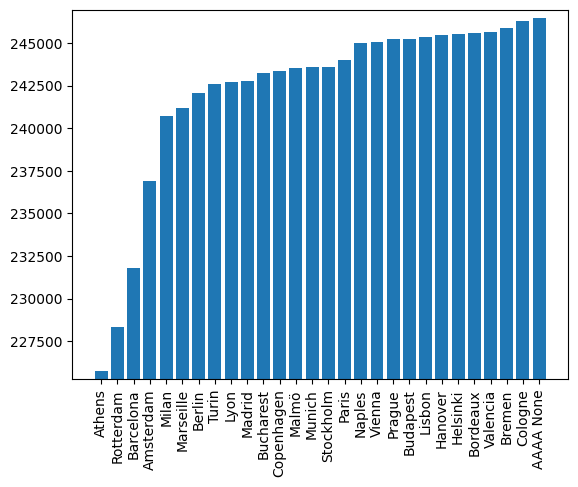

In [156]:
# histogram  of pond_vect
plt.bar([x[2] for x in Pond_vect], [x[1] for x in Pond_vect])
plt.xticks(rotation=90)
offset = 500
plt.ylim(Pond_vect[0][1] - offset, Pond_vect[-1][1] + offset)
plt.show()

In [169]:
def better_extra_hub(alpha, port = False):
    '''returns the better extra hub for a given alpha'''
    df = pd.read_csv('data/results_alpha.csv')
    df = df.loc[df['alpha']==alpha]
    for i, x in df.iterrows():
        if port:
            return x['extra_hub']
        else:
            if not x['extra_hub'] in [p[2:] for p in PORTS]:
                return x['extra_hub']

def saved_with_hub(extra_hub):
    # returns the saved cost and emissions with the extra placed hub
    s_cost = 0
    s_emissions = 0
    for w in range(10):
        df_cities_weight = df_norm.iloc[weight::10,:]
        for p in range(len(PORTS)):
            for h in range(len(HUBS)):
                for c in range(len(CITIES)):
                    

In [174]:
best = better_extra_hub(1)
print(best)

Marseille
